In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import plotly.express as px

data = pd.read_csv(f"tweetsdata_16.csv")

In [16]:
#calculate tweets per hashtag
users = data['Username']
num_each_hashtag = {
    'climatechange':0,
    'climatecrisis': 0,
    'climatestrikeonline': 0,
    'agw': 0,
    'globalwarming': 0,
    'savetheplanet': 0,
    'climateemergency': 0  
}

num_users_per_hashtag = {
    'climatechange':0,
    'climatecrisis': 0,
    'climatestrikeonline': 0,
    'agw': 0,
    'globalwarming': 0,
    'savetheplanet': 0,
    'climateemergency': 0  
}

#lists for checking individual users per hashtag
users_in_climatechange = []
users_in_climatecrisis = []
users_in_climatestrikeonline = []
users_in_agw = []
users_in_globalwarming = []
users_in_savetheplanet = []
users_in_climateemergency = []

for index, tweet in enumerate(data['Hashtags']):
    if 'agw' in tweet or 'AGW' in tweet:
        num_each_hashtag['agw'] += 1
        if not users[index] in users_in_agw:
            users_in_agw.append(users[index])
            num_users_per_hashtag['agw'] += 1
            
    if 'climatechange' in tweet:
        num_each_hashtag['climatechange'] += 1
        if not users[index] in users_in_climatechange:
            users_in_climatechange.append(users[index])
            num_users_per_hashtag['climatechange'] += 1
            
    if 'climatecrisis' in tweet:
        num_each_hashtag['climatecrisis'] += 1
        if not users[index] in users_in_climatecrisis:
            users_in_climatecrisis.append(users[index])
            num_users_per_hashtag['climatecrisis'] += 1
            
    if 'climatestrikeonline' in tweet:
        num_each_hashtag['climatestrikeonline'] += 1
        if not users[index] in users_in_climatestrikeonline:
            users_in_climatestrikeonline.append(users[index])
            num_users_per_hashtag['climatestrikeonline'] += 1
            
    if 'globalwarming' in tweet:
        num_each_hashtag['globalwarming'] += 1
        if not users[index] in users_in_globalwarming:
            users_in_globalwarming.append(users[index])
            num_users_per_hashtag['globalwarming'] += 1
        
    if 'savetheplanet' in tweet:
        num_each_hashtag['savetheplanet'] += 1
        if not users[index] in users_in_savetheplanet:
            users_in_savetheplanet.append(users[index])
            num_users_per_hashtag['savetheplanet'] += 1
        
    if 'climateemergency' in tweet:
        num_each_hashtag['climateemergency'] += 1
        if not users[index] in users_in_climateemergency:
            users_in_climateemergency.append(users[index])
            num_users_per_hashtag['climateemergency'] += 1

print(num_each_hashtag)

{'climatechange': 604, 'climatecrisis': 516, 'climatestrikeonline': 168, 'agw': 2, 'globalwarming': 528, 'savetheplanet': 476, 'climateemergency': 270}


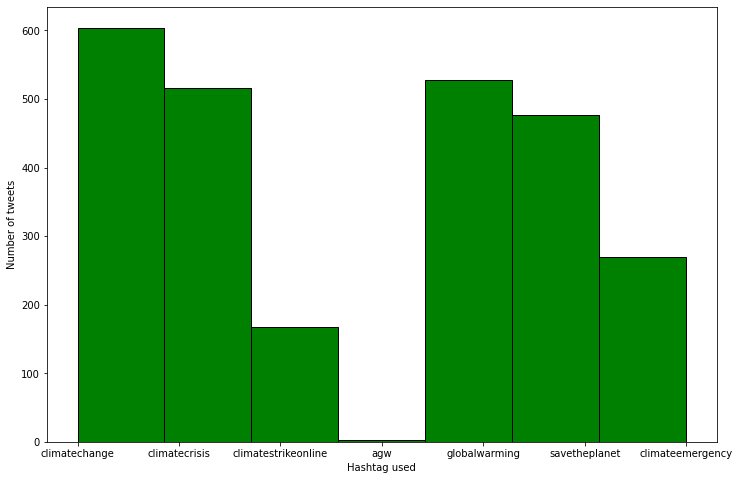

In [17]:
#show number of tweets per hashtag
plt.figure(figsize=(12,8))
list = [key for key, val in num_each_hashtag.items() for _ in range(val)]
plt.hist(list, bins=7, color='green',edgecolor='black')
plt.ylabel('Number of tweets')
plt.xlabel('Hashtag used')
plt.show()

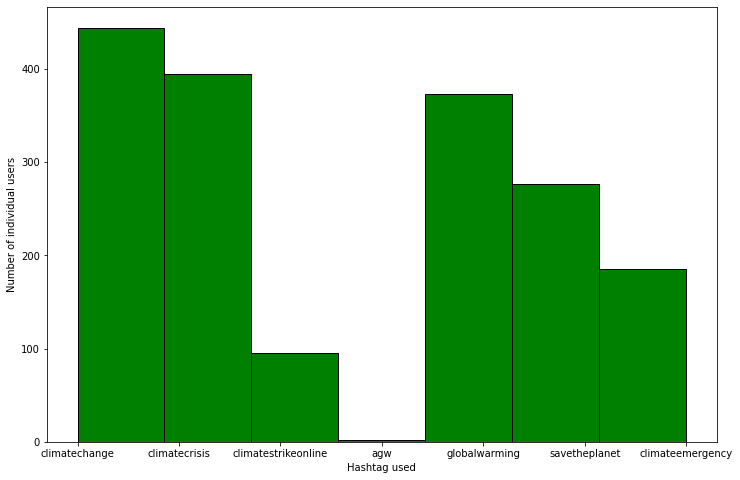

In [18]:
#show number of users per hashtag
plt.figure(figsize=(12,8))
list = [key for key, val in num_users_per_hashtag.items() for _ in range(val)]
plt.hist(list, bins=7, color='green',edgecolor='black')
plt.ylabel('Number of individual users')
plt.xlabel('Hashtag used')
plt.show()

{'en': 2220, 'th': 4, 'und': 295, 'fr': 25, 'pl': 1, 'es': 31, 'tl': 3, 'zh': 0, 'it': 5, 'et': 1, 'pt': 6, 'ja': 4, 'de': 8, 'ur': 0, 'sv': 1, 'cy': 0, 'fa': 0, 'hi': 16, 'ta': 3, 'ro': 4}


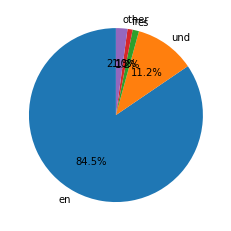

In [19]:
#language of tweets
num_each_lang = {
    'en':0,
    'th': 0,
    'und': 0,
    'fr': 0,
    'pl': 0,
    'es': 0,
    'tl': 0,
    'zh': 0,
    'it':0,
    'et': 0,
    'pt': 0,
    'ja': 0,
    'de': 0,
    'ur': 0,
    'sv': 0,
    'cy': 0,
    'fa': 0,
    'hi': 0,
    'ta': 0,
    'ro': 0
}

#labels and datalist for most popular languages
labels = ['en', 'und', 'es', 'fr', 'other']
languages = [0,0,0,0,0]

for lang in data['Language']:
    if lang == 'en':
        num_each_lang['en'] += 1
        languages[0] += 1
    if lang == 'th':
        num_each_lang['th'] += 1
        languages[4] += 1
    if lang == 'und':
        num_each_lang['und'] += 1
        languages[1] += 1
    if lang == 'fr':
        num_each_lang['fr'] += 1
        languages[3] += 1
    if lang == 'pl':
        num_each_lang['pl'] += 1
        languages[4] += 1
    if lang == 'es':
        num_each_lang['es'] += 1
        languages[2] += 1
    if lang == 'tl':
        num_each_lang['tl'] += 1
        languages[4] += 1
    if lang == 'zh':
        num_each_lang['zh'] += 1
        languages[4] += 1
    if lang == 'it':
        num_each_lang['it'] += 1
        languages[4] += 1
    if lang == 'et':
        num_each_lang['et'] += 1
        languages[4] += 1
    if lang == 'pt':
        num_each_lang['pt'] += 1
        languages[4] += 1
    if lang == 'ja':
        num_each_lang['ja'] += 1
        languages[4] += 1
    if lang == 'de':
        num_each_lang['de'] += 1
        languages[4] += 1
    if lang == 'ur':
        num_each_lang['ur'] += 1
        languages[4] += 1
    if lang == 'sv':
        num_each_lang['sv'] += 1
        languages[4] += 1
    if lang == 'cy':
        num_each_lang['cy'] += 1
        languages[4] += 1
    if lang == 'fa':
        num_each_lang['fa'] += 1
        languages[4] += 1
    if lang == 'hi':
        num_each_lang['hi'] += 1
        languages[4] += 1
    if lang == 'ta':
        num_each_lang['ta'] += 1
        languages[4] += 1
    if lang == 'ro':
        num_each_lang['ro'] += 1
        languages[4] += 1

print(num_each_lang)

fig1, ax1 = plt.subplots()
ax1.pie(languages, labels=labels, autopct='%1.1f%%', startangle=90)

plt.show()

In [24]:
#vader tool analysis
analyzer = SentimentIntensityAnalyzer()
vader_data = []
for index, sentence in enumerate(data['Text']):
    vs = analyzer.polarity_scores(sentence)
    vader_data.append(vs)
    #print("{} {}".format(index, vs))
    
fig = px.scatter_ternary(vader_data, a="neg", b="neu", c="pos")
fig.show()